In [1]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END, MessagesState
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode

load_dotenv()

# class AgentState(TypedDict):
#     messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

def model(state: MessagesState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

def tools_router(state: MessagesState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return END
    

tool_node = ToolNode(tools=tools)

graph = StateGraph(MessagesState)

graph.add_node("model", model)
graph.add_node("tool_node", tool_node)
graph.set_entry_point("model")

graph.add_conditional_edges("model", tools_router)
graph.add_edge("tool_node", "model")

app = graph.compile()


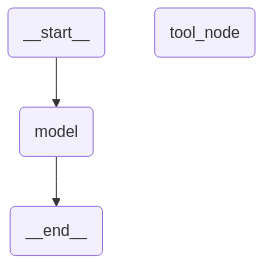

In [2]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [3]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="values")

for event in events: 
    print(event["messages"])

[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='9e5b9c60-e5c1-4fcd-ac53-32e19fb53780')]
[HumanMessage(content="What's the current weather in Bangalore?", additional_kwargs={}, response_metadata={}, id='9e5b9c60-e5c1-4fcd-ac53-32e19fb53780'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3zt0', 'function': {'arguments': '{"query": "Bangalore current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.028, 'prompt_time': 0.018826634, 'queue_time': 0.20396864099999998, 'total_time': 0.046826634}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a56f6eea01', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-db3bc60e-4afb-4eb8-a974-29cdf6560229-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Bangalore current we

In [5]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

events = app.stream(input=input, stream_mode="updates")

for event in events: 
    print(event)

{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pzvq', 'function': {'arguments': '{"query": "Bangalore current weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 286, 'total_tokens': 307, 'completion_time': 0.028, 'prompt_time': 0.013804902, 'queue_time': 0.045980863999999996, 'total_time': 0.041804902}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a56f6eea01', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3c55bb2d-e180-479b-a6be-b3f7aabec9fc-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Bangalore current weather'}, 'id': 'call_pzvq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 286, 'output_tokens': 21, 'total_tokens': 307})]}}
{'tool_node': {'messages': [ToolMessage(content='[{"title": "Weather in Bangalore in April 2025 (State of Karnātaka)", "url": "https://world-weather.

In [6]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'e3453a39-e2be-4f5d-b39a-7c59036d41e3', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='32ccafdf-98d6-4681-bb78-4e894767adac')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '7c49b200-bda1-4bd1-b653-8e7a649b6faf', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:218dbc3b-8e62-f821-e658-c34cc8bb2658'}, 'parent_ids': ['e3453a39-e2be-4f5d-b39a-7c59036d41e3']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='32ccafdf-98d6-4681-bb78-4e894767adac')]]}}, 'name': 'ChatGroq', 'tags': ['seq:s

In [ ]:
input = {
    "messages": ["Hi, how are you?"]
}

events = app.astream_events(input=input, version="v2")

async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True)

I'm functioning properly, thanks for asking. How can I assist you today?